# Primary Biliary Cirrhosis: exploratory analysis

The original dataset is available on the [Mayo Clinic website](https://www.mayo.edu/research/documents/pbcseqhtml/doc-10027141).

To compare this with the preprocessed version in Putzel (2021) and Lee (2020, [see code](https://github.com/chl8856/Dynamic-DeepHit)), use the following snippet:

    data2 = list()
    with open ("../data/PBC2_cleaned_deephit.csv") as f:
        cols = next(f).strip().split(",")
        for line in f:
            data2.append(line.strip().split(","))
    df2 = pd.DataFrame(data2, columns=cols)

The following pre-processing steps seem to have been applied in the version used in the papers mentioned above:

- `tte`: approximately converted in weeks (exact rule eludes me...)
- `day`: renamed `times`, approximately converted in weeks)
- `age`: converted in years (divided by 365.24)
- `ascites`, `hepatomegaly`, `edema`: missing values left blank.
- `edema`: values (0.0, 0.5, 1.0) are relabeled with (0, 1, 2).
- `serChol`, `alkaline`, `platelets`: missing values are replaced by mean.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from tdsurv.utils import kaplan_meier

## Parse the data

In [2]:
def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return float("nan")

def safe_int(x):
    try:
        return int(x)
    except ValueError:
        return float("nan")

cols = (
    # Case number
    ("id", int),
    # Number of days between registration and the earlier of death, transplantion, or study analysis time.
    ("tte", float),
    # Status: 0 = alive, 1 = transplanted, 2 = dead.
    ("label", int),
    # Drug: 1 = D-penicillamine, 0 = placebo.
    ("drug", int),
    # Age in days, at registration.
    ("age", float),
    # Sex: 0 = male, 1 = female.
    ("sex", int),
    # Day: number of days between enrollment and this visit date, remaining values on the line of data refer to this visit.
    ("day", float),
    # Presence of ascites: 0 = no, 1 = yes.
    ("ascites", safe_int),
    # Presence of hepatomegaly: 0 = no, 1 = yes.
    ("hepatomegaly", safe_int),
    # Presence of spiders: 0 = no, 1 = yes.
    ("spiders", safe_int),
    # Presence of edema:
    # - 0.0 = no edema and no diuretic therapy for edema,
    # - 0.5 = edema present without diuretics, or edema resolved by diuretics,
    # - 1.0 = edema despite diuretic therapy.
    ("edema", float),
    # Serum bilirubin in mg/dl.
    ("serBilir", float),
    # Serum cholesterol in mg/dl.
    ("serChol", safe_float),
    # Albumin in gm/dl.
    ("albumin", float),
    # Alkaline phosphatase in U/liter
    ("alkaline", safe_float),
    # SGOT in U/ml (serum glutamic-oxaloacetic transaminase).
    ("SGOT", float),
    # Platelets per cubic ml / 1000.
    ("platelets", safe_float),
    # Prothrombin time in seconds.
    ("prothrombin", float),
    # Histologic stage of disease in (1, 2, 3, 4).
    ("histologic", int),
)

names, funcs = zip(*cols)

In [3]:
data = list()
with open("../data/DOC-10026794.dat") as f:
    for line in f:
        data.append([f(elem) for elem, f in zip(line.strip().split(), funcs)])
df = pd.DataFrame(data, columns=names)

print("Number of observations: {:,}".format(len(df)))

Number of observations: 1,945


In [4]:
df.head(10)

,id,tte,label,drug,age,sex,day,ascites,hepatomegaly,spiders,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic
0,1,400.0,2,1,21464.0,1,0.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,1718.0,138.0,190.0,12.2,4
1,1,400.0,2,1,21464.0,1,192.0,1.0,1.0,1.0,1.0,21.3,NaN,2.94,1612.0,6.2,183.0,11.2,4
2,2,5169.0,0,1,20617.0,1,0.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,7395.0,113.5,221.0,10.6,3
3,2,5169.0,0,1,20617.0,1,182.0,0.0,1.0,1.0,0.0,0.8,NaN,3.60,2107.0,139.5,188.0,11.0,3
4,2,5169.0,0,1,20617.0,1,365.0,0.0,1.0,1.0,0.0,1.0,NaN,3.55,1711.0,144.2,161.0,11.6,3
5,2,5169.0,0,1,20617.0,1,768.0,0.0,1.0,1.0,0.0,1.9,NaN,3.92,1365.0,144.2,122.0,10.6,3
6,2,5169.0,0,1,20617.0,1,1790.0,1.0,1.0,1.0,0.5,2.6,230.0,3.32,1110.0,131.8,135.0,11.3,3
7,2,5169.0,0,1,20617.0,1,2151.0,1.0,1.0,1.0,1.0,3.6,NaN,2.92,996.0,131.8,100.0,11.5,3
8,2,5169.0,0,1,20617.0,1,2515.0,1.0,1.0,1.0,1.0,4.2,NaN,2.73,860.0,145.7,103.0,11.5,3
9,2,5169.0,0,1,20617.0,1,2882.0,1.0,1.0,1.0,1.0,3.6,244.0,2.80,779.0,119.0,113.0,11.5,3


## Exploratory analysis

### Length of sequences

Number of patients / sequences: 312


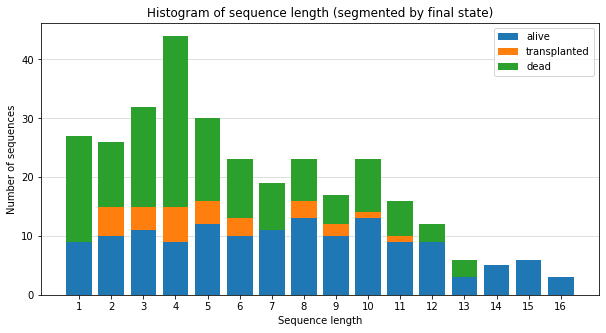

In [5]:
agg = df.groupby("id")["day"]
bins = np.arange(1, 17)
labels = ["alive", "transplanted", "dead"]

print("Number of patients / sequences: {:,}".format(len(agg)))

fig, ax = plt.subplots(figsize=(10, 5))

cumul = np.zeros(len(bins))
for i in (0, 1, 2):
    vals = df[df.label == i].groupby("id")["day"].count().values
    cnts, _ = np.histogram(vals, bins=np.arange(1, 18))
    ax.bar(bins, cnts, bottom=cumul, label=labels[i])
    cumul += cnts

ax.set_xticks(bins)
ax.grid(axis="y", alpha=0.5)
ax.set_axisbelow(True)
ax.set_title("Histogram of sequence length (segmented by final state)")
ax.set_xlabel("Sequence length")
ax.set_ylabel("Number of sequences")
ax.legend()

### Time interval between adjacent observations

Note on the Mayo website:

> One "feature" of the data deserves special comment.
> The last observation before death or liver transplant often has many more missing covariates than other data rows.
> The original clinical protocol for these patients specified visits at 6 months, 1 year, and annually thereafter.
> At these protocol visits lab values were obtained for a large pre-specified battery of tests.
> "Extra" visits, often undertaken because of worsening medical condition, did not necessarily have all this lab work.
> The missing values are thus potentially informative, and violate the usual "missing at random" (MCAR or MAC) assumptions that are assumed in analyses.
> Because of the earlier published results on the Mayo PBC risk score, however, the 5 variables involved in that computation were usually obtained, i.e., age, bilirubin, albumin, prothrombin time, and edema score.

In [6]:
first = list()
second = list()
tail = list()
for seq in agg.apply(list).values:
    deltas = np.diff(seq)
    first.extend(deltas[0:1])
    second.extend(deltas[1:2])
    tail.extend(deltas[2:])

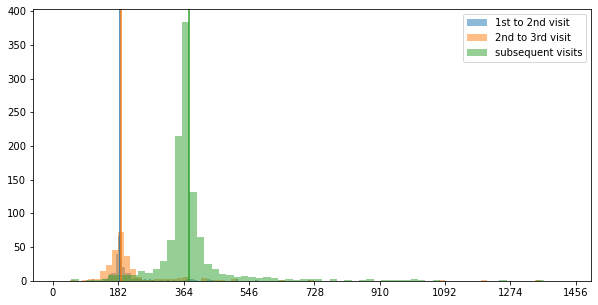

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(first, bins=100, alpha=0.5, label="1st to 2nd visit")
ax.axvline(np.median(first), color=plt.cm.tab10(0))

ax.hist(second, bins=100, alpha=0.5, label="2nd to 3rd visit")
ax.axvline(np.median(second), color=plt.cm.tab10(1))

ax.hist(tail, bins=100, alpha=0.5, label="subsequent visits")
ax.axvline(np.mean(tail), color=plt.cm.tab10(2))
ax.set_xticks(np.arange(0, 2000, 182))
ax.set_xlim(xmax=1500)
ax.legend()

### Distribution of time-to-event

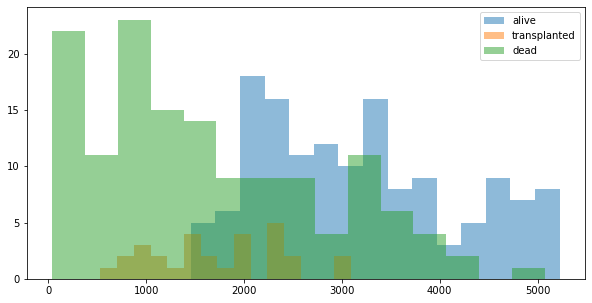

In [8]:
first = df.groupby("id").first()
fig, ax = plt.subplots(figsize=(10, 5))

for i in (0, 1, 2):
    res = first[first.label == i]["tte"].values
    ax.hist(res, alpha=0.5, label=labels[i], bins=15)
ax.legend()

### Missing data

In [9]:
cols = [
    "ascites",
    "hepatomegaly",
    "spiders",
    "serChol",
    "alkaline",
    "platelets",
]

df[cols].isna().sum()

ascites          60
hepatomegaly     61
spiders          58
serChol         821
alkaline         60
platelets        73
dtype: int64

### Timelines

In [10]:
visits = df.groupby("id")["day"].apply(list).values
ttes = df.groupby("id")["tte"].first().values
labels = df.groupby("id")["label"].first().values

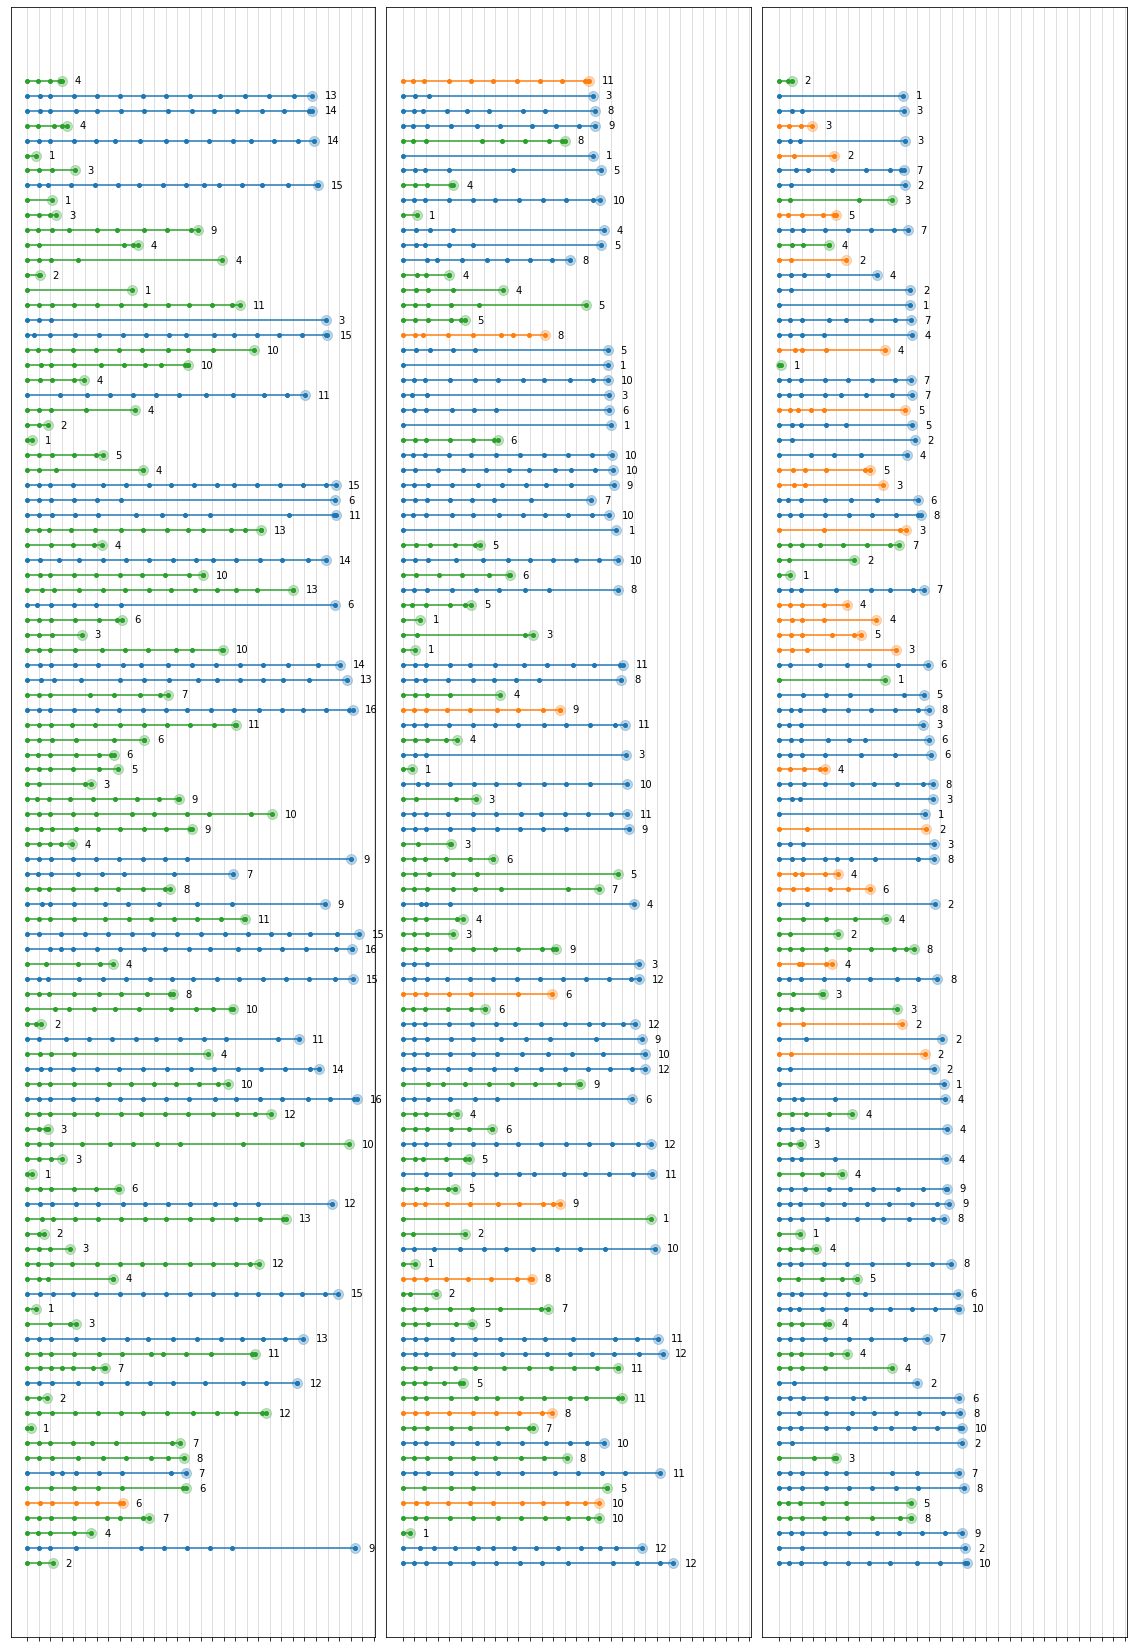

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 30), sharex=True)

for ax, offset in ((ax1, 0), (ax2, 100), (ax3, 200)):
    for i in range(offset, offset + 100):
        color = plt.cm.tab10(labels[i])
        xs = np.append(visits[i], ttes[i])
        ys = (i - offset) * np.ones_like(xs)
        ax.plot(xs, ys, marker="o", ms=4, color=color)
        ax.scatter(ttes[i], i - offset, s=100, alpha=0.3, color=color)
        ax.text(ttes[i] + 200, i - offset, str(len(visits[i])), va="center")
    ax.set_yticks([])
    ax.set_xticks(np.arange(0, 5500, 182))
    ax.set_xticklabels([])
    ax.grid(axis="x", alpha=0.5)

fig.subplots_adjust(wspace=0.03)
#ax.grid(axis="x")

### Distribution of features

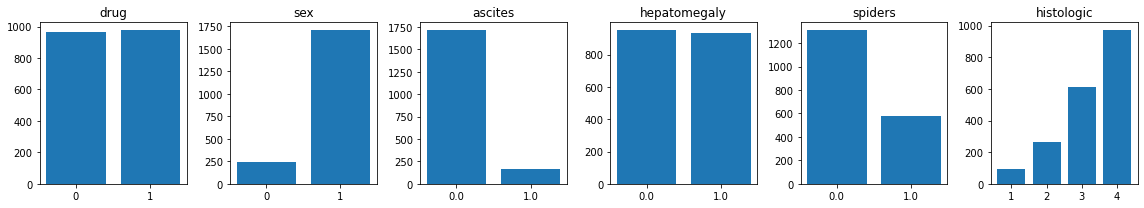

In [12]:
cat_feats = (
    "drug",
    "sex",
    "ascites",
    "hepatomegaly",
    "spiders",
    "histologic",
)

fig, axs = plt.subplots(ncols=len(cat_feats), figsize=(16, 3))
for ax, col in zip(axs, cat_feats):
    cnt = df[col].value_counts().sort_index()
    idx = np.arange(len(cnt))
    ax.bar(idx, cnt.values)
    ax.set_xticks(idx)
    ax.set_xticklabels(cnt.index)
    ax.set_title(col)
fig.tight_layout()

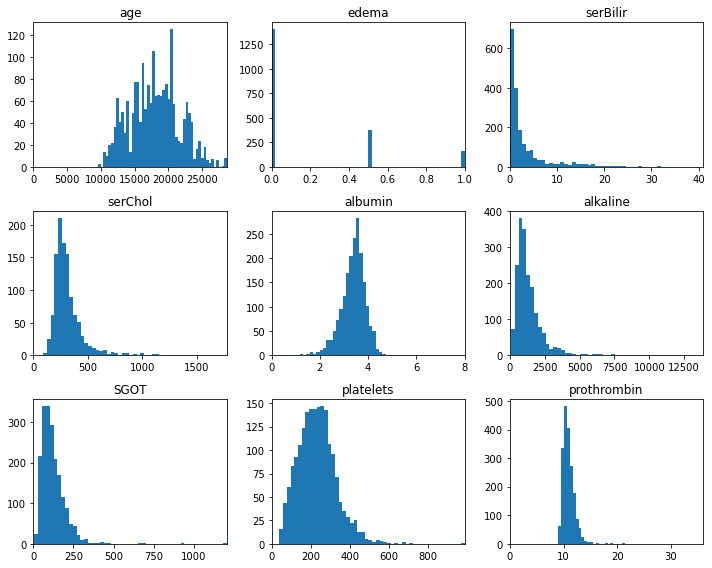

In [13]:
cont_feats = (
    "age",
    "edema",
    "serBilir",
    "serChol",
    "albumin",
    "alkaline",
    "SGOT",
    "platelets",
    "prothrombin",
)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
for ax, col in zip(axs.ravel(), cont_feats):
    vals = df[col].dropna().values
    ax.hist(vals, bins=50)
    ax.set_title(col)
    ax.set_xlim(xmin=0, xmax=vals.max())
fig.tight_layout()

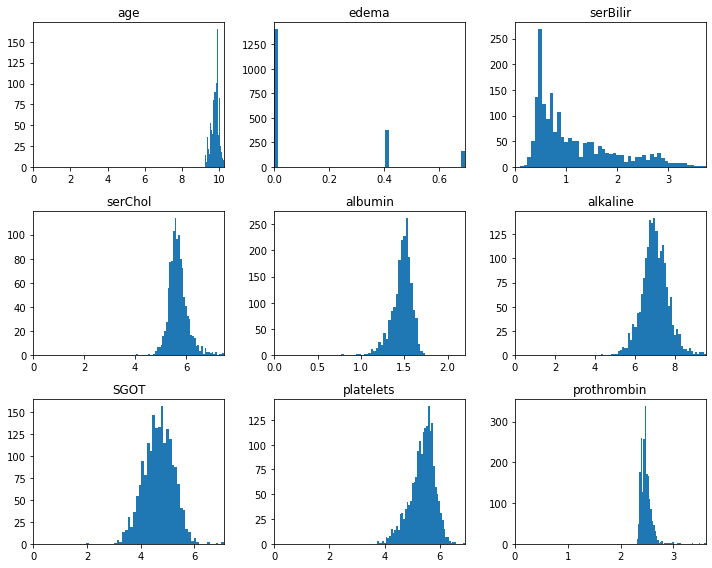

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
for ax, col in zip(axs.ravel(), cont_feats):
    vals = np.log1p(df[col].dropna().values)
    ax.hist(vals, bins=50)
    ax.set_title(col)
    ax.set_xlim(xmin=0, xmax=vals.max())
fig.tight_layout()

Suggestions based on this:

- `age`: center and normalize
- `serBilir`, `serChol`, `albumin`, `alkaline`, `SGOT`, `platelets`, `prothrombin`: use `log1p` transform, center.


## Transforming the data into final form

Relevant bit in Murtaugh et al., 1994.

> As in the earlier Mayo modeling efforts, patients were censored at the time of transplantation.

**Important note**: in transforming continous-time sequences to discrete-time ones, we are currently losing some information.
In particular, for censored observations we currently assume that censoring happens *at the time of the last observation*.

In fact, that is not correct: censoring happens at transplantation or study analysis time.
But since we do not observe explicitly the state of the patient at the "true" time of censoring, it does not play well with the current implementation of our inference algorithms.

In [15]:
final = df.copy()

cols_with_missing_data = [
    "ascites",
    "hepatomegaly",
    "spiders",
    "serChol",
    "alkaline",
    "platelets",
]

# Add indicator variable for missing data & replace with median.
for col in cols_with_missing_data:
    mask = final[col].isna()
    # final[f"{col}_missing"] = mask.astype(float)
    final.loc[mask, col] = final[col].median()

# `age`: center and normalize.
final["age"] = (df["age"] - df["age"].mean()) / df["age"].std()

cols_log1p = (
    "serBilir",
    "serChol",
    "albumin",
    "alkaline",
    "SGOT",
    "platelets",
    "prothrombin",
)

# Log-transform and center continuous variables
for col in cols_log1p:
    final[col] = np.log1p(final[col]) - np.mean(np.log1p(final[col]))

# Delete unnecessary columns.
final.drop("day", axis=1, inplace=True)
final.drop("tte", axis=1, inplace=True)

# Transform dataframe into sequences

# Censoring indicator & time-to-event.
agg = final.groupby("id")["label"]
cs = (agg.first() != 2).values
ts = agg.count().values - cs.astype(int)

# Sequences in dense format.
final.drop("label", axis=1, inplace=True)
agg = final.groupby("id")
cols = agg.any().columns.tolist()
n = len(agg)  # Number of sequences
d = len(cols)  # Number of features
m = agg["drug"].count().max()  # Max. length of sequence
seqs = np.zeros((n, m, d))
for j, col in enumerate(cols):
    for i, seq in enumerate(agg[col].apply(list)):
        k = len(seq)
        seqs[i,:k,j] = seq

### Empirical survival curve

Text(0.5, 1.0, 'Kaplan-Meier estimate of survival')

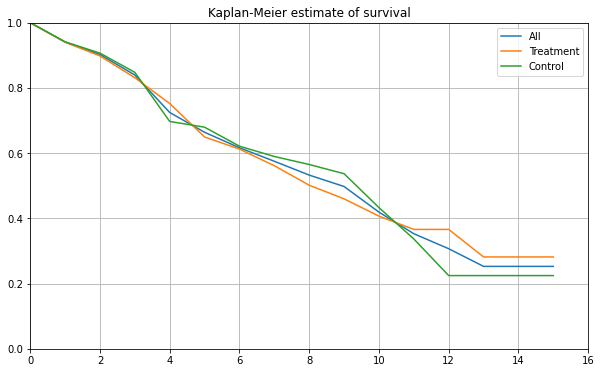

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
    
ys = kaplan_meier(ts, cs)
ax.plot(ys, label="All")

mask = (agg["drug"].first() == 1).values
ys = kaplan_meier(ts[mask], cs[mask])
ax.plot(ys, label="Treatment")
ys = kaplan_meier(ts[~mask], cs[~mask])
ax.plot(ys, label="Control")

ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xlim(xmin=0, xmax=16)
ax.grid(axis="both")
ax.legend()
ax.set_title("Kaplan-Meier estimate of survival")

### Saving the data

In [17]:
with open("../data/pbc-seqs.pkl", "wb") as f:
    pickle.dump({
        "seqs": seqs,
        "cs": cs,
        "ts": ts,
        "cols": cols,
    }, f)